In [8]:
# Third-party imports
from math import ceil
import os
import vrplib

# Own imports
from src.new.display import DisplayModel
from src.new.ants import FreeAnt
from src.new.acs import AS
from src.new.helpers import create_directory, download_instance, get_distances_matrix
from src.new.heuristics import HeuristicModel
from src.new.metaheuristics import GeneralVNS
from src.new.models import VRPModel

In [9]:
# Parameters to handle the algorithm
%matplotlib inline

ALPHA = 1  # 0.75, 1, 1.05, 1.1, 1.25, 1.5, 1.75, 2
ANTS_NUM_RELATION = 2.5  # 1, 2
BETA = 2  # 2, 2.5, 3,  3.5
CANDIDATE_NODES_TYPE = 'best'  # None, 'best', 'random'
GAMMA = 3  # 1, 1.5 2
HEURISTICS_TO_USE = ['distance', 'saving'] # ['distance'], ['saving'], ['distance', 'saving']
ITERATION_LOCAL_SEARCH_MODEL = None  # None, GeneralVNS
MAX_ITERATIONS = 500
MIN_ITERATIONS = 200
PHEROMONES_UPDATE_TYPE = 'g_best' # 'all_ants', 'it_best', 'g_best', 'pseudo_g_best'
PROBABILITIES_MATRIX_TYPE = 'classic'  # 'classic', 'normalized'
RHO = 0.2  # 0.05, 0.1, 0.15, 0.2, 0.25, 0.3
TARE_PERCENTAGE = 0.15

# Instance to solve
LIB = 'CMT'
INSTANCE = 'CMT2'

# Parameters to handle the display
PLOT_INSTANCE = False
PLOT_CLUSTERS = False
PLOT_SOLUTION = True
PLOT_MOST_USED_ARCS = False
PLOT_PHEROMONES_MATRIX = False

In [10]:
# Initialize everything
project_path = os.getcwd()
instance_file_exists = os.path.isfile(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')

if not instance_file_exists:
    create_directory(f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}/')
    success = download_instance(
        INSTANCE, f'{project_path}/instances/CVRPLIB/{LIB}/')

    if not success:
        raise Exception('Error downloading the instance')


instance = vrplib.read_instance(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.vrp')
solution = vrplib.read_solution(
    f'{project_path}/instances/CVRPLIB/{LIB}/{INSTANCE}.sol')

demands = instance['demand']
nodes = [node for node in range(len(demands))]
clients = nodes[1:]
max_capacity = instance['capacity']
matrix_coords = instance['node_coord']
k_optimal = ceil(sum(demands)/max_capacity)

optimal_cost = None
if solution['cost']:
    optimal_cost = solution['cost']
else:
    optimal_cost = float(instance['comment']) if instance['comment'] else None

errors = VRPModel.validate_instance(nodes, demands, max_capacity)
if errors:
    raise Exception(errors)

iterations = max(round(len(nodes), -2), MIN_ITERATIONS)
matrix_distances = get_distances_matrix(nodes, matrix_coords)

parameters_heuristics = {
    'demands': demands,
    'importance_distances': BETA,
    'importance_savings': GAMMA,
    'matrix_coords': matrix_coords,
    'max_capacity': max_capacity,
    'nodes': nodes[:],
    'normalization': None,
}

heuristics = HeuristicModel(**parameters_heuristics)
matrix_heuristics = heuristics.get_heuristic_matrix(HEURISTICS_TO_USE)

parameters_ants = {
    'alpha': ALPHA,
    'ants_num': ceil(len(clients) / ANTS_NUM_RELATION), 
    'demands': demands,
    'ipynb': True,
    'k_optimal': k_optimal,
    'matrix_costs': matrix_distances,
    'matrix_heuristics': matrix_heuristics,
    'max_capacity': max_capacity,
    'max_iterations': min(iterations, MAX_ITERATIONS),
    'model_ant': FreeAnt,
    'model_ls_it': ITERATION_LOCAL_SEARCH_MODEL,
    'model_problem': VRPModel,
    'nodes': nodes,
    'rho': RHO,
    'tare': max_capacity * TARE_PERCENTAGE,
    'type_candidate_nodes': CANDIDATE_NODES_TYPE,
    'type_pheromones_update': PHEROMONES_UPDATE_TYPE,
    'type_probabilities_matrix': PROBABILITIES_MATRIX_TYPE,
}

In [11]:
# Render the problem

if PLOT_INSTANCE:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_problem(nodes, demands, matrix_coords, instance_name)

In [12]:
# Run the algorithm

ant_system = AS(**parameters_ants)
results = ant_system.solve()


PARAMETERS
----------------------------------------
AS:
	alpha: 1
	ants_num: 30
	beta: 1
	demands: 76
	evaporation_rate: 0.8
	iterations_local_search: no
	k_optimal: 10
	lst_clusters: no
	max_capacity: 140
	max_iterations: 200
	min_demand: 1, max_demand: 37, mean: 17.94736842105263
	model_ant: Free Ant
	nodes: 75
	rho: 0.2
	t_max: 1.00000000000000000000000000000000000000000000000000
	t_min: 0.00000000000000000000000000000000000000000000000000
	t_zero: 0.50000000000000000000000000000000000000000000000000
	tare: 21.0
	type_candidate_nodes: best
	type_pheromones_update: g_best
	type_probabilities_matrix: classic




Global Best -> 1131.08536: 100%|██████████| 200/200 [00:07<00:00, 27.66it/s]


-- Time elapsed: 7.2349042892456055 --

BEST SOLUTION FOUND: (1131.0853610423712, [[0, 75, 43, 64, 42, 41, 56, 23, 63, 49, 0], [0, 26, 10, 53, 7, 35, 54, 19, 8, 72, 0], [0, 67, 21, 36, 48, 5, 37, 15, 71, 0], [0, 45, 30, 2, 62, 28, 74, 68, 0], [0, 4, 69, 47, 61, 22, 1, 73, 33, 0], [0, 17, 55, 24, 50, 18, 32, 3, 51, 0], [0, 29, 70, 60, 20, 57, 13, 27, 52, 34, 0], [0, 14, 59, 11, 66, 65, 0], [0, 6, 25, 9, 39, 12, 40, 0], [0, 16, 44, 31, 38, 58, 46, 0]], 10, [140, 139, 136, 136, 135, 140, 140, 138, 127, 133])
Best 5 solutions: [(1131.0853610423712, 10, [140, 139, 136, 136, 135, 140, 140, 138, 127, 133]), (1132.7346477007293, 10, [140, 139, 136, 140, 135, 140, 138, 133, 137, 126]), (1136.8469969197906, 10, [140, 139, 136, 140, 140, 135, 138, 137, 126, 133]), (1141.0032246344676, 10, [140, 137, 138, 135, 136, 140, 140, 133, 138, 127]), (1141.6180410023815, 10, [140, 139, 136, 140, 135, 135, 134, 136, 138, 131])]


Optimal cost: 835.262
Best cost: 1131.0853610423712
Difference %: 35.42


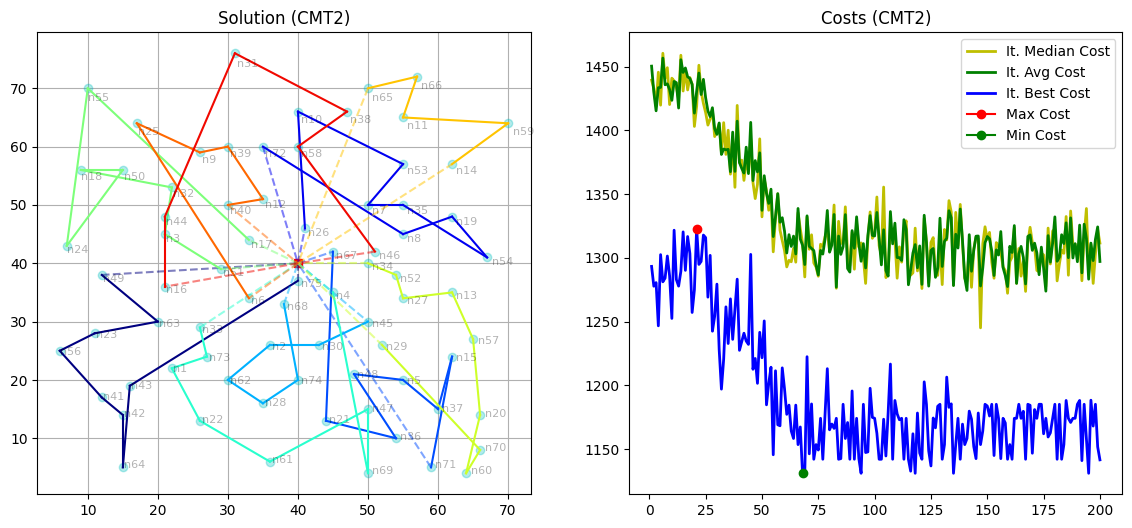

In [13]:
if optimal_cost:
    print(f'Optimal cost: {optimal_cost}')
    print(f'Best cost: {results["global_best_solution"]["cost"]}')
    print(f'Difference %: {round((results["global_best_solution"]["cost"] - optimal_cost) / optimal_cost * 100, 2)}')
    
if PLOT_SOLUTION:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.render_solution(results['global_best_solution'], matrix_coords, instance_name, results['best_solutions'], results['iterations_mean_costs'], results['iterations_median_costs'])

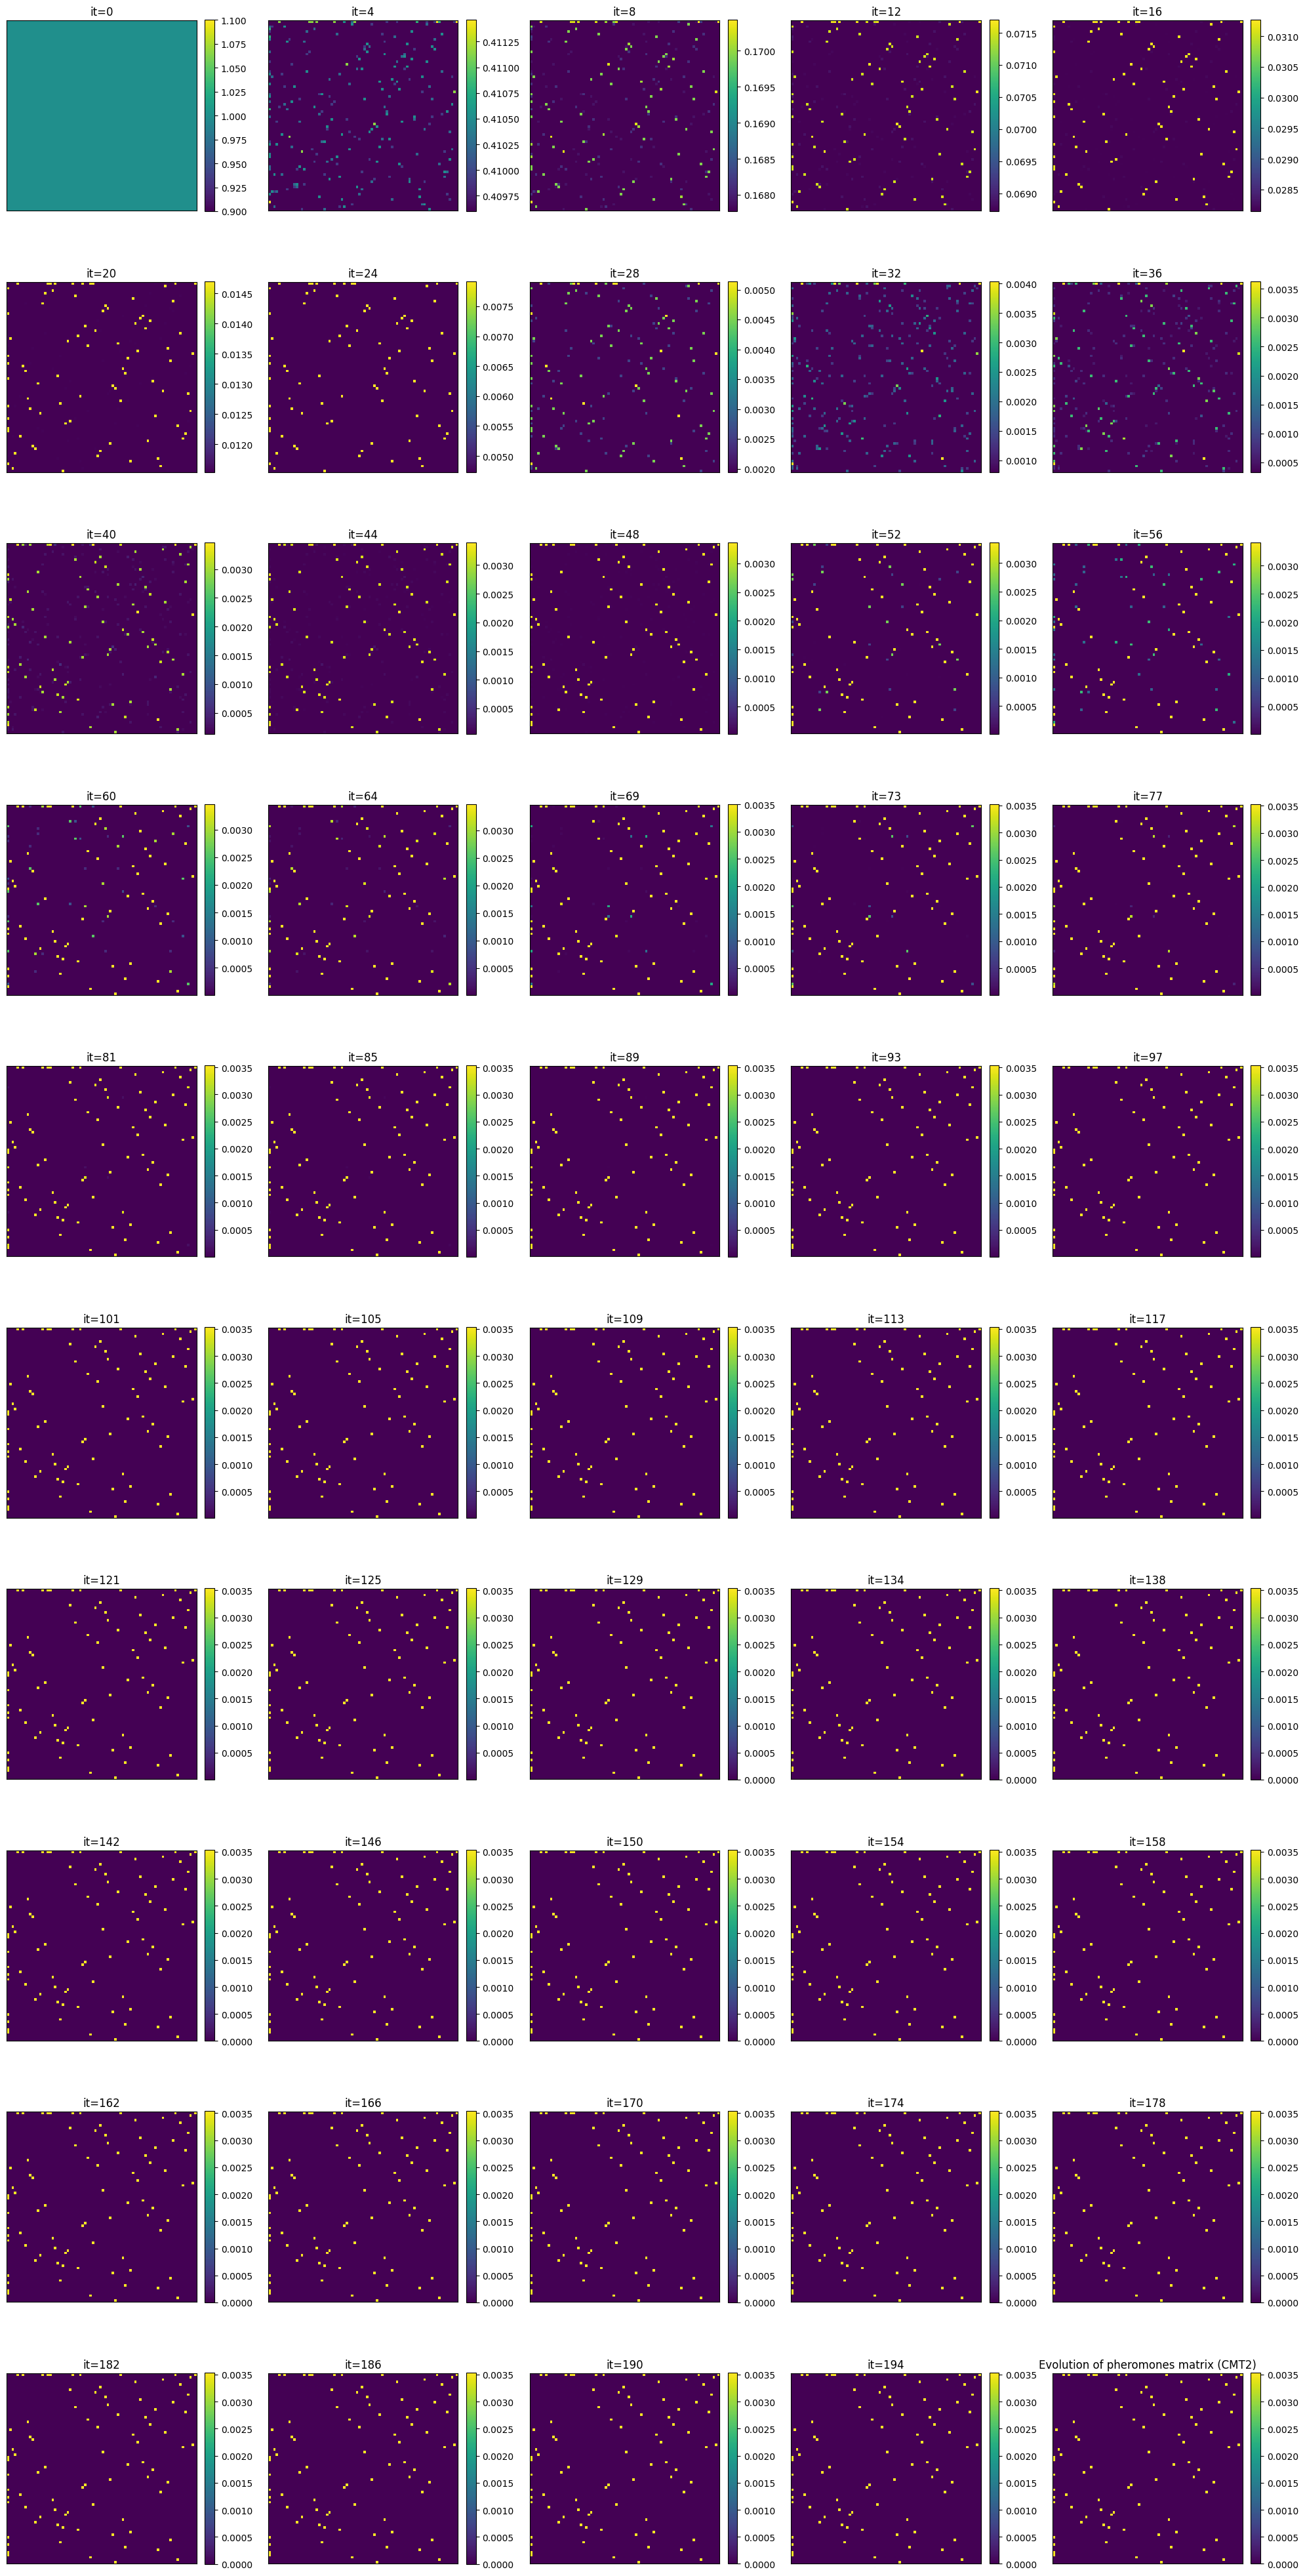

In [14]:
if PLOT_PHEROMONES_MATRIX:
    instance_name = INSTANCE.split('/')[-1]
    DisplayModel.plot_pheromones_matrices(results['pheromones_matrices'], instance_name, max_plots=50)